## Final project. Applied Mathematics / Numerical Analysis / P1.4

Using Lagrangian finite elements with Chebyshev nodes, defined on square, of arbitrary order

Find the solution of 

$$
-\Delta \mathbf u + \mathbf u = \mathbf f \text{ in } \Omega, \qquad n \cdot \delta u = 0 \text{ on } \partial \Omega
$$

on the square $\Omega = [0,1]^2$. For the sake of simplicity you can consider just **one finite element** and homogeneous Neumann boundary conditions. 

The above problem can be rewritten in matrix form as

$$
A u = (K+M) u =  b
$$

where $K$ is the stiffness matrix, and $M$ is the mass matrix.

In order to do so, express $u$ as a linear combination of basis functions, multiply from the left with a basis function, and integrate by parts the laplacian to obtain:

$$
K_{ij} := \int_\Omega \nabla v_i \cdot \nabla v_j,\qquad M_{ij} = \int_\Omega v_i v_j, \qquad b_i = \int_\Omega v_i f
$$

In [1]:
%pylab inline
import numpy as np
import pylab as pl
import sympy as sym
from mpl_toolkits.mplot3d import Axes3D

Populating the interactive namespace from numpy and matplotlib


### 1 Construct (or use the available functions from numpy/scipy) the chebishev nodes of given order

Once you constructed them, plot them.

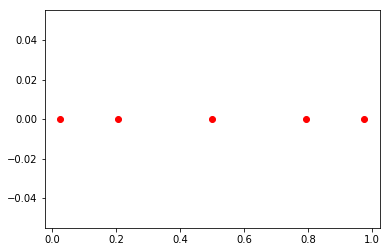

In [2]:
order = 5 # You should be able to change this, and everything else should work accordingly

# Call C the chebishev nodes between 0 and 1

# YOUR CODE HERE to fill C
C = (np.polynomial.chebyshev.chebgauss(order)[0]+1)/2

#print - plot
_ = pl.plot(C, zeros(order), 'ro')
#print(C)

### 2 Construct (or use the available functions from numpy/scipy) the one-dimensional Lagrange basis functions on the Chebishev nodes
Make sure each entry of basis_1d is a callable function, that you can evaluate at a given point. Plot all of the basis functions, using a numpy array `Vs`, storing all basis functions evaluated on evenly spaced points, called `s`

Vs.shape = (257, 5)


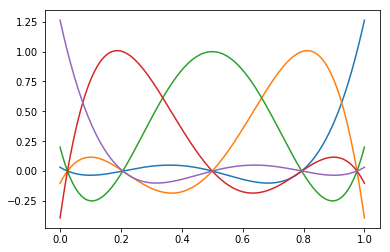

In [3]:
plot_resolution = 257

basis_1d = [] 
# YOUR CODE HERE to fill basis_1d
for i in range(order):
    basis_1d.append(lambda x,k=i: np.product([(x-C[j])/(C[k]-C[j]) for j in range(order) if j != k], axis=0))
    # k=i... Thanks Jacopo 

Vs = zeros((plot_resolution, order))

# YOUR CODE HERE to fill Vs
# Vs[:,0] = basis_1d[0](s)
# ...
                    
## Example plot:
# s = linspace(0, 1, plot_resolution)
# plot(s, Vs)

s = linspace(0, 1, plot_resolution)

for i in range(order):
    Vs[:,i] = basis_1d[i](s)

_ = plot(s, Vs)
print("Vs.shape = "+str(Vs.shape))

### 3 Construct three one-dimensional quadrature formulas, to integrate the matrices, the right hand side, and the error

In general the size of the quadratures should be selectable by the user.

Anything that should be evaluated on one of quadrature points, should be named accordingly (i.e., using a suffix `m,r,e`) for the three collections

In [4]:
quadrature_size_matrices = 8
quadrature_size_rhs      = 9
quadrature_size_error    = 10

# Qm, Wm = ...  # place here the code to get the quadrature points and weights
# Qr, Wr = ...  # place here the code to get the quadrature points and weights
# Qe, We = ...  # place here the code to get the quadrature points and weights

# YOUR CODE HERE
def q_w (size):
    q, w = np.polynomial.legendre.leggauss(size)
    q = .5 * (q + 1)
    w = .5 * w
    return q, w

#for q, v, size in [(Qm,Wm, quadrature_size_matrices),(Qr,Wr, quadrature_size_rhs),(Qe,We, quadrature_size_error)]:
#    q, w = q_w(size)
Qm, Wm = q_w(quadrature_size_matrices)
Qr, Wr = q_w(quadrature_size_rhs)
Qe, We = q_w(quadrature_size_error)
print Qm.shape
print Wm.shape
print Qr.shape
print Wr.shape
print Qe.shape
print We.shape

(8,)
(8,)
(9,)
(9,)
(10,)
(10,)


### 4 Evaluate all the one dimensional basis functions at each collection of quadrature points

Store the results in three different numpy arrays, one for quadrature. Use suffix `m,r,e` for the arrays representing the basis functions evaluated at the quadrature points to be used for the matrices, rhs, and errors respectively.

In [5]:
Vm = zeros((quadrature_size_matrices, order))
Vr = zeros((quadrature_size_rhs,      order))
Ve = zeros((quadrature_size_error,    order))


def eval_func_points(basis, q, v):
    for i in range(len(q)):
        v[i] = [ basis[j](q[i]) for j in range(len(basis))]

for q, v in [(Qm,Vm),(Qr,Vr),(Qe,Ve)]:
    eval_func_points( basis_1d, q, v)
    assert basis_1d[1](q[0])==v[0][1], 'why basis_1d[0](q[0]) is '+str(basis_1d[0](q[0]))+' instead of '+str(v[0][0])+'?'
print("Vm.shape = "+str(Vm.shape))

Vm.shape = (8, 5)


### 5 Evaluate the derivatives of the basis functions at each collection of quadrature points

Store the results in three different numpy arrays, one for quadrature. Use suffix `m,r,e` for the arrays representing the basis functions evaluated at the quadrature points to be used for the matrices, rhs, and errors respectively.

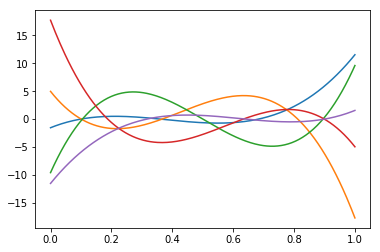

In [6]:
Dm = zeros((quadrature_size_matrices, order))
Dr = zeros((quadrature_size_rhs,      order))
De = zeros((quadrature_size_error,    order))

def der (f, n=1):
    t = sym.var('t')
    g = f(t)
    return sym.lambdify(t, g.diff(t, n), 'numpy')

basis_1d_der = []
for f in basis_1d:
    basis_1d_der.append(der(f))

for q, d in [(Qm,Dm),(Qr,Dr),(Qe,De)]:
    eval_func_points( basis_1d_der, q, d)

Vs_der = zeros((plot_resolution, order))
for i in range(order):
    Vs_der[:,i] = basis_1d_der[i](s)

_ = plot(s, Vs_der)

### 6 Construct the two dimensional quadrature formulas as tensor products of the one dimensional ones

Given two one dimensional quadrature formulas with points $x_r$ and $y_q$, we can construct the corresponding two dimensional quadrature formulas by using `einsum` to obtain the weights of higher dimensional tensor product quadrature formulas, on the points $(x_r, y_q)$:

$$
X_{qr} = (x_r, y_q),  J2_{qr} = w_r w_q
$$

Use lexycographical ordering w.r.t. to C: `x` runs faster than `y`.

Integration of a scalar function of two variables on the square can then be approximated as

$$
\int_0^1 \int_0^1 f(x,y) dx \, dy \sim \sum_{r=0}^{n_q-1}\sum_{q=0}^{n_q-1} f(x_r, y_q)  w_r w_q = \sum_{r=0}^{n_q-1}\sum_{q=0}^{n_q-1} f(X_{qr})  J_{qr}
$$


In [7]:
W2m = einsum('q,r -> qr',Wm, Wm)
W2r = einsum('q,r -> qr',Wr, Wr)
W2e = einsum('q,r -> qr',We, We)

W2r.shape

(9, 9)

### 7 Construct the two dimensional basis functions as tensor products of the one dimensional ones

Given a set of one dimensional basis functions, one can construct the tensor product space for two dimensional problems by defining

$$
V_{ij}(x,y) := v_i(y) v_j(x), \quad i,j = 0,\ldots,n-1.
$$

If we only need these to be evaluated at some quadrature points, $V_{iq} = v_i(x_q)$, we can construct the corresponding two dimensional basis functions by using `einsum` to obtain higher dimensional arrays on tensor product points:

$$
V2_{qr\, ij} =  v_i(y_q) v_j(x_r)
$$

representing one two dimensional basis function (identified by the two indices $i,j$, one indicating the $j$-th basis function along $x$, and the other identifying the $i$-th basis function along $y$), evaluated at the point $(x_r, y_q)$.

Notice that we use lexycographical ordering: `x` runs faster than `y`, both for the numbering of the basis functions and for the order of the quadrature points. Moreover, we group together the indices running over the quadrature poitns, and the ones running over the basis function indices, while maintaining the lexycographical ordering.

This allows you to resize the arrays, so that the results only have two dimensional matrices, with shape `(quadrature_size_xxx^2,order^2)`. 

In [8]:
### Now it is consistent with what we have done: first indeces for points then the indices for the polynomials

V2s = einsum('qi, rj -> qrij', Vs, Vs)

V2m = einsum('qi, rj -> qrij', Vm, Vm)
V2r = einsum('qi, rj -> qrij', Vr, Vr)
V2e = einsum('qi, rj -> qrij', Ve, Ve)

# ...

VDm = einsum('qi, rj -> qrij', Vm, Dm)
DVm = einsum('qi, rj -> qrij', Dm, Vm)

print(V2s.shape)
print(V2m.shape)
print(V2e.shape)
print(VDm.shape)

(257, 257, 5, 5)
(8, 8, 5, 5)
(10, 10, 5, 5)
(8, 8, 5, 5)


Notice that, since you used the correct ordering, you can actually plot some of the basis functions, for example the 2 along x, 3 along y, as:

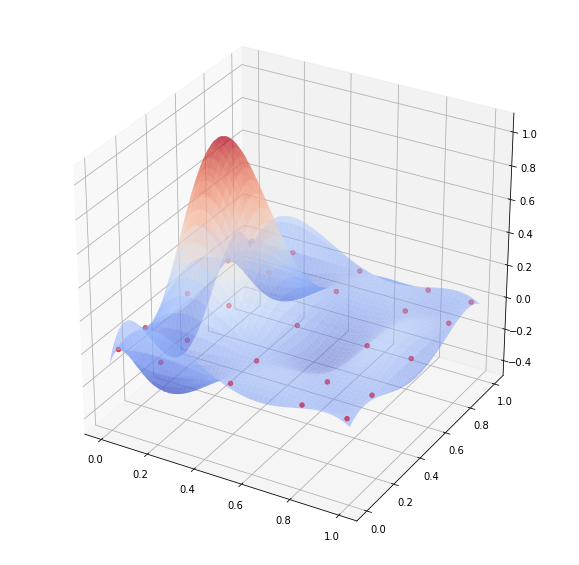

In [9]:


X = meshgrid(s, s)
Q = meshgrid(C, C)


fig = figure(figsize=[10,10])
ax = fig.gca(projection='3d')
surf2 = ax.plot_surface(X[0], X[1], V2s[:,:,2,3], rstride=5, cstride=5, cmap=cm.coolwarm, alpha=0.5)
scatter = ax.scatter(Q[0], Q[1], zeros_like(Q[0]), c='r', marker='o')

### 8 Assemble the matrices and the right hand side

Using `einsum`, assemble the arrays representing the matrices and then resize them to be two-dimensional. Careful on how the stiffness matrix is defined:

$$
K_{ij \, kl} = \int_{\Omega} \nabla v_{ij} \cdot \nabla v_{kl} = \sum_q \sum_r (v'_j(x_r)v_i(y_q) v'_l(x_r)v_k(y_q) +v_j(x_r)v'_i(y_q) v_l(x_r)v'_k(y_q) )w_r w_q
$$

Using summation convention, this is equivalent to:

```
(Vm[i][q]*Dm[j][r] Vm[k][q]*Dm[l][r] + Dm[i][q]*Vm[j][r] *Dm[k][q]Vm[l][r])W[r]*W[q]
```
or
```
(VDm[q][r][i][j]^2 + DVm[q][r][i][j]^2)W2[q,r]
```

In [10]:
M = einsum('qrij, qrkl, q, r', V2m, V2m, Wm, Wm)
M = einsum('qrij, qrkl, qr', V2m, V2m, W2m)
print("M.shape = "+str(M.shape))
print("M.shape = "+str(M.shape))

M = M.reshape((order**2, order**2))
print("M.shape = "+str(M.shape))

# Your code here to assemble and reshape K
K_left = einsum('qrij, qrkl, qr', VDm, VDm, W2m)
K_right = einsum('qrij, qrkl, qr', DVm, DVm, W2m)
K = K_left + K_right
#K=zeros((order,order,order,order))
#for i in range(order):
#    for j in range(order):
#        for k in range(order):
#            for l in range(order):
#                for r in range(quadrature_size_matrices):
#                    for q in range(quadrature_size_matrices):
#K[i,j,k,l] += (Vm[q][i]*Dm[r][j]* Vm[q][k]*Dm[r][l] + Dm[q][i]*Vm[r][j]*Dm[q][k]*Vm[r][l])*Wm[r]*Wm[q]

print("K.shape = "+str(K.shape))
K = K.reshape((order**2, order**2))
print("K.shape = "+str(K.shape))
A = K+M
print("A.shape = "+str(A.shape))
print Vm


M.shape = (5, 5, 5, 5)
M.shape = (5, 5, 5, 5)
M.shape = (25, 25)
K.shape = (5, 5, 5, 5)
K.shape = (25, 25)
A.shape = (25, 25)
[[ 0.00505612 -0.0163433   0.03256656 -0.0679204   1.04664102]
 [-0.03517267  0.11624531 -0.24970031  0.77046668  0.39816099]
 [ 0.01532619 -0.05321696  0.13935163  0.95172177 -0.05318262]
 [ 0.04342075 -0.16722282  0.86902999  0.3189449  -0.06417282]
 [-0.06417282  0.3189449   0.86902999 -0.16722282  0.04342075]
 [-0.05318262  0.95172177  0.13935163 -0.05321696  0.01532619]
 [ 0.39816099  0.77046668 -0.24970031  0.11624531 -0.03517267]
 [ 1.04664102 -0.0679204   0.03256656 -0.0163433   0.00505612]]


### 9 Using a known solution, construct a right hand side that would produce the given solution, and assemble it

Given a solution that satisfies the boundary conditions (for example:) 

$$
u(x,y) = \cos(\pi x)\cos(3\pi y)
$$
compute its laplacian, put a minus in front of it, and sum $u$ to it. The result is the forcing term $f$ that you have to use in order to obtain $u$ as a solution to the problem. Call it `my_function`, compute the right hand side by integrating with the basis functions and reshape it to be a vector of size `order^2`:

Vr.shape = (9, 5)
Fr.shape = (9, 9)
W2r.shape = (9, 9)
[ 8.54894943e-01  2.08739468e+00  8.18789481e-16 -2.08739468e+00
 -8.54894943e-01 -1.05893837e+00 -2.58560696e+00 -9.29161262e-16
  2.58560696e+00  1.05893837e+00 -3.01841885e-16  4.74880552e-17
 -1.28261117e-16  4.52491777e-16  1.24019176e-16  1.05893837e+00
  2.58560696e+00  1.01324114e-15 -2.58560696e+00 -1.05893837e+00
 -8.54894943e-01 -2.08739468e+00 -7.24369024e-16  2.08739468e+00
  8.54894943e-01]


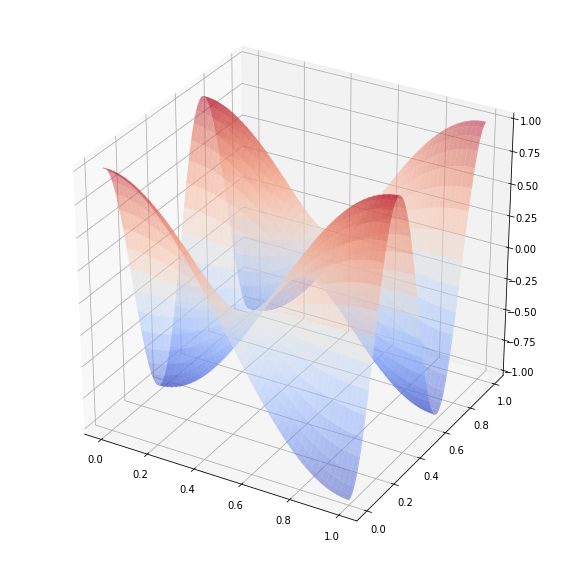

In [11]:
def laplacian(u):
    assert len(u.free_symbols) == 2, "I can only do this for two variables functions..."
    x, y = u.free_symbols
    return sym.lambdify((x, y), - (u.diff(x, 2) + u.diff(y, 2)) + u, "numpy" )



x = sym.var('x')
y = sym.var('y')
u_ex = sym.cos(sym.pi*x)*sym.cos(3*sym.pi*y)
u_e = sym.lambdify((x, y), u_ex, 'numpy')

fig = figure(figsize=[10,10])
ax = fig.gca(projection='3d')
X = meshgrid(s, s)
surf3 = ax.plot_surface(X[0], X[1], u_e(X[0],X[1]), rstride=5, cstride=5, cmap=cm.coolwarm, alpha=0.5)

Q2r = meshgrid(Qr,Qr)
f= laplacian(u_ex)
Fr = f(Q2r[0], Q2r[1])
print("Vr.shape = "+str(Vr.shape))
print("Fr.shape = "+str(Fr.shape))
print("W2r.shape = "+str(W2r.shape))
b = einsum('qrij, qr, qr', V2r, Fr, W2r)
b = b.reshape((order**2))
print b

### 10 Solve the linear system, and plot the solution

Use a direct solver to solve the linear system. Once you have the coefficients `u` as a vector, reshape it to a matrix, and use einsum to have its values on the `s` space.

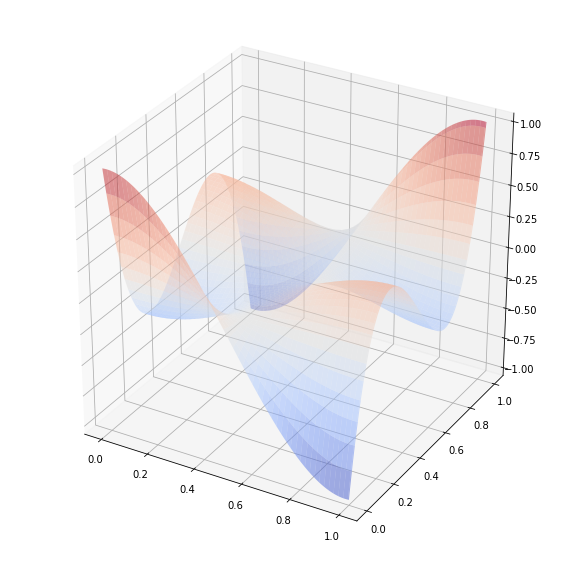

In [12]:
u = solve(A,b)
u = reshape(u, (order, order))

us = einsum('qrij, ij', V2s, u)

X = meshgrid(s, s)
Q = meshgrid(C, C)

fig = figure(figsize=[10,10])
ax = fig.gca(projection='3d')
surf2 = ax.plot_surface(X[0], X[1], us, rstride=5, cstride=5, cmap=cm.coolwarm, alpha=0.5)


### 11 Compute the L2 error of the solution

The L2 error is defined as 

$$
\| u - u_h \| := \sqrt{\int_\Omega (u(x,y) - u^{ij} V_{ij}(x,y))^2 dx\, dy } \sim \sqrt{\sum_q \sum_r (u(x_r, y_q) -V_{qrij} u^{ij})^2 W_{qr}}
$$

use the quadrature formula and the matrix you constructed above to compute the approximate solutions at the quadrature points.

In [13]:

Q2e = meshgrid(Qe, Qe)
r = u_e(Q2e[0], Q2e[1])
l = einsum('qrij, ij', V2e, u)
err= einsum('qr, qr', np.square(r - l), W2e)

print( err)

0.08710092087666338


### 12 Group together all of the above in a function

The function should take as input the `degree` of the one dimensional basis space, the degrees of the three quadrature formulas, a number of points where you want to produce the outputs.

Once you have the function, create a `log-log` plot of the L2 error with respect to the input degree

In [14]:
%reset -f
%pylab inline
import numpy as np
import pylab as pl
import sympy as sym
from mpl_toolkits.mplot3d import Axes3D
from time import clock


def solver(degree, m_order, r_order, e_order, resolution, f_rhs, solution = 0, method2solve = solve):
    
    def q_w (size):
        q, w = np.polynomial.legendre.leggauss(size)
        q = .5 * (q + 1)
        w = .5 * w
        return q, w
    
    def eval_func_points(basis, q, v):
        for i in range(len(q)):
            v[i] = [ basis[j](q[i]) for j in range(len(basis))]
    
    def der (f, n=1):
        t = sym.var('t')
        g = f(t)
        return sym.lambdify(t, g.diff(t, n), 'numpy')
    
    C = (np.polynomial.chebyshev.chebgauss(degree)[0]+1)/2
    basis_1d = []
    for i in range(degree):
        basis_1d.append(lambda x,k=i: np.product([(x-C[j])/(C[k]-C[j]) for j in range(degree) if j != k], axis=0))
    
    basis_1d_der = []
    for l in basis_1d:
        basis_1d_der.append(der(l))

    
    Vs = zeros((resolution, degree))
    s = linspace(0, 1, resolution)
    for i in range(degree):
        Vs[:,i] = basis_1d[i](s)

    Qm, Wm = q_w(m_order)
    Qr, Wr = q_w(r_order)
    Vm = zeros((m_order, degree))
    Vr = zeros((r_order,      degree))
    Dm = zeros((m_order, degree))
    Dr = zeros((r_order,      degree))
    for q, v in [(Qm,Vm),(Qr,Vr)]:
        eval_func_points( basis_1d, q, v)
    for q, d in [(Qm,Dm),(Qr,Dr)]:
        eval_func_points( basis_1d_der, q, d)
    
    W2m = einsum('q,r -> qr',Wm, Wm)
    W2r = einsum('q,r -> qr',Wr, Wr)
    V2s = einsum('qi, rj -> qrij', Vs, Vs)

    V2m = einsum('qi, rj -> qrij', Vm, Vm)
    V2r = einsum('qi, rj -> qrij', Vr, Vr)

    VDm = einsum('qi, rj -> qrij', Vm, Dm)
    DVm = einsum('qi, rj -> qrij', Dm, Vm)
    
    M = einsum('qrij, qrkl, qr', V2m, V2m, W2m)
    M = M.reshape((degree**2, degree**2))
    K_left = einsum('qrij, qrkl, qr', VDm, VDm, W2m)
    K_right = einsum('qrij, qrkl, qr', DVm, DVm, W2m)
    K = K_left + K_right
    K = K.reshape((degree**2, degree**2))

    A = K+M
    
    Q2r = meshgrid(Qr,Qr)
    Fr = f_rhs(Q2r[0], Q2r[1])
    b = einsum('qrij, qr, qr', V2r, Fr, W2r)
    b = b.reshape((degree**2))
    
    u = method2solve(A,b)
    u = reshape(u, (degree, degree))
    us = einsum('qrij, ij', V2s, u)
    X = meshgrid(s, s)
    
    if solution != 0:
        
        Qe, We = q_w(r_order)
        Ve = zeros((r_order,    degree))
        eval_func_points( basis_1d, Qe, Ve)
        De = zeros((r_order,    degree))
        eval_func_points( basis_1d, Qe, De)
        W2e = einsum('q,r -> qr',We, We)
        V2e = einsum('qi, rj -> qrij', Ve, Ve)
        
        Q2e = meshgrid(Qe, Qe)
        r = solution(Q2e[0], Q2e[1])
        l = einsum('qrij, ij', V2e, u)
        err = einsum('qr, qr', np.square(r - l), W2e)
        return X, us, err
    return X, us

Populating the interactive namespace from numpy and matplotlib


In [20]:
def laplacian(u):
    assert len(u.free_symbols) == 2, "I can only do this for two variables functions..."
    x, y = u.free_symbols
    return sym.lambdify((x, y), - (u.diff(x, 2) + u.diff(y, 2)) + u, "numpy" )

x = sym.var('x')
y = sym.var('y')
u_ex = sym.cos(sym.pi*x)*sym.cos(3*sym.pi*y)
u_ex_lambda = sym.lambdify((x, y), u_ex, 'numpy')
f = laplacian(u_ex)
## EXAMPLE
#X, u_s = solver(7,8,9,10,257,f)
#fig = figure(figsize=[10,10])
#ax = fig.gca(projection='3d')
#surf2 = ax.plot_surface(X[0], X[1], u_s, rstride=5, cstride=5, cmap=cm.coolwarm, alpha=0.5)

def err_test( degrees = range(3,19,2), method = [solve], o_m = 24, o_r = 25, o_e = 26, _res = 257 ):
    errors = {}
    time = {}
    for m in method:
        errors[m] = []
        time[m] = []
        print "****"
        for deg in degrees:
            start = clock()
            errors[m].append(solver(deg,o_m,o_r,o_e,_res,f, u_ex_lambda, m)[2])
            end = clock()
            time[m].append(end - start)
            print deg, errors[m][-1], time[m][-1]
        print "****"
    return degrees, errors, time

degrees, errors, timings = err_test(o_m = 12, o_r = 15, o_e = 17)

****
3 0.27376392654360765 0.0644
5 0.08709923842927411 0.252909
7 0.0025964920178985487 0.657863
9 2.0649527103039437e-05 1.21887
11 6.332599906748641e-08 2.314388
13 0.0017161212710612307 3.852923
15 188.74817289597542 5.424613
17 20032057936339.582 7.636144
****


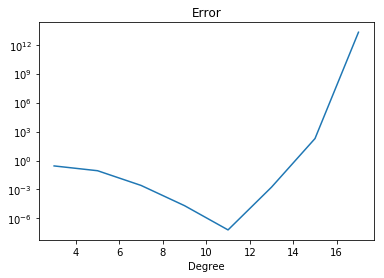

In [21]:
_ = pl.semilogy(degrees, errors[solve])
_ = pl.title("Error")
_ = pl.xlabel('Degree')

### 13 [OPTIONAL] Augment the function above

Make it take an optional argument that switches from a direct to an iterative solver (use CG, with a simple preconditioner of your choice).

Make a plot of cost it takes to run with iterative VS direct solvers. Is there a cross over point? For what degree?

****
3 0.2737639265437225 0.048933
4 0.08709923842938788 0.132325
5 0.08709923842938765 0.32116
6 0.002596492018012771 0.447611
7 0.0025964920180123244 0.684674
8 2.0649527216208646e-05 1.090228
9 2.0649527216195202e-05 1.575847
10 6.332610691514343e-08 2.080061
11 6.332610691450436e-08 2.504128
12 9.128357880104727e-11 3.275418
13 9.128357878878235e-11 3.763263
14 7.020281413074407e-14 4.810269
15 7.020281342127473e-14 6.10354
16 3.1483479139131364e-17 7.237562
17 3.148348146338253e-17 8.63376
18 8.796919635019727e-21 10.429193
19 8.796661707955986e-21 12.685282
20 1.6331973619808875e-24 14.223962
21 1.6162308585028475e-24 16.337657
22 1.8640366273842162e-26 18.413604
23 5.5749361719616036e-27 21.394826
24 1.0488129100992564e-25 24.266934
****
****
3 0.27376392654372256 0.108828
4 0.08709923842938791 0.146245
5 0.08709923842938762 0.305616
6 0.002596492018012769 0.456093
7 0.00259649201801232 0.806012
8 2.0649527216208646e-05 1.113864
9 2.0649527216195202e-05 1.654052
10 6.33261069151

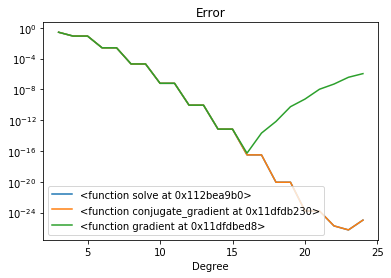

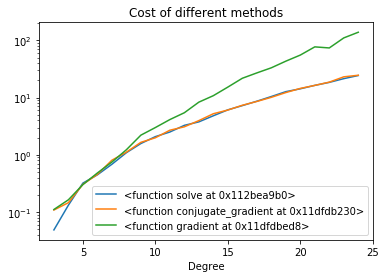

In [17]:
def conjugate_gradient(A, b):
    P = A #P = A <- Same results as solve
    nmax=len(A)
    eps=1e-10
    N=len(A)
    x = zeros_like(b)
    tol = eps + 1
    it = 0
    r = b - dot(A,x)
    rho_old = 1.
    p_old = zeros_like(b)
    while (it < nmax and tol > eps):
        it += 1
        z = linalg.solve(P,r)
        rho = dot(r,z)
        if (it > 1):
            beta = rho/rho_old
            p = z + beta*p_old
        else:
            p = z
        q = dot(A,p)
        alpha = rho/(dot(p,q))
        x += p*alpha
        r -= q*alpha
        p_old = p
        rho_old = rho
        tol = linalg.norm(r,2)
    return x

def gradient(A, b):
    P = identity(len(A))
    nmax=8000
    eps=1e-10
    n=len(A)
    x= zeros_like(b)
    tol = eps +1
    r = b - dot(A,x)
    it = 0
    while (it<nmax and tol>eps):
        z = linalg.solve(P,r)
        alpha = dot(r,z)/(dot(z,dot(A,z)))
        x += z*alpha
        r -= dot(A,z)*alpha
        tol = linalg.norm(r,2)
        it += 1
    return x

methods = [solve, conjugate_gradient, gradient]
degrees, errors, timings = err_test(range(3,25,1), methods)
for met in methods:
    _ = pl.semilogy(degrees, errors[met])
_ = pl.legend(methods)
_ = pl.title("Error")
_ = pl.xlabel('Degree')
pl.show()
for met in methods:
    _ = pl.semilogy(degrees, timings[met])
_ = pl.legend(methods)
_ = pl.title("Cost of different methods")
_ = pl.xlabel('Degree')
pl.show()

### 14 [OPTIONAL] Matrix free

Using the iterative solver, implement a matrix-free approach where the computation of the matrices is substituted with a  function that returns the *matrix-vector* product. In doing so, you must take care of rewriting the assemble of the matrix as a sum of many *matrix-matrix* products exploiting all the possible tensor products. 

Compare and comment the compuational cost of 100 matrix-vector product when the matrix is assembled and when it is computed on-the-fly as a function of the degree of the finite element. Is there a cross-over point? Is matrix free always convenient?

To see an explanation of how matrix free works, take a look at this page: 

https://www.dealii.org/8.5.0/doxygen/deal.II/step_37.html